# 1. Introduction

# 2. Preparation 1

## 2.1 packages

In [1]:
import pandas as pd
import numpy as np
import random
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import recall_score, precision_score, f1_score
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

random.seed(5291)
warnings.filterwarnings('ignore')


## 2.2 Data Cleaning and Wrangling

In [12]:
stroke_raw = pd.read_csv('stroke.csv')
cleaned_data = stroke_raw
print("Data size: " + str(stroke_raw.shape))
stroke_raw.head(5)

Data size: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [13]:
# Drop ID, because not useful
cleaned_data = stroke_raw.drop('id', axis=1)

# gender
# Male=0, Female=1, Other=2
# Drop other, because there is only one 'other'
gender_map = {'Male': 0, 'Female': 1, 'Other': 2}
cleaned_data['gender'] = cleaned_data['gender'].apply(lambda x: gender_map[x])
cleaned_data = cleaned_data[cleaned_data['gender'] != 2]


# age - drop age and creat age labels
# kids 0-18, young 18-45, midle_aged 45-62, seniors > 62
bins = [0, 18, 45, 62, float('inf')]
labels = [0, 1, 2, 3]  # 0: kids, 1: young, 2: middle_aged, 3: seniors
cleaned_data['age'] = pd.cut(cleaned_data['age'], bins=bins, labels=labels, right=False)
cleaned_data['age'] = cleaned_data['age'].cat.codes

# ever_married
# not married=0, married=1
cleaned_data['ever_married'] = cleaned_data['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)

# Residence_type
# Rural=0, Urban=1
cleaned_data['Residence_type'] = cleaned_data['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)

# smoking_status
# never smoked=0, formerly smoked=1, smokes=2, Unknown=3
smoke_map = {'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, "Unknown":3}
cleaned_data['smoking_status'] = cleaned_data['smoking_status'].apply(lambda x: smoke_map[x])

# work_type
# never worked=0, private=1, self-employed=2, govt_job=3
cleaned_data['work_type'] = cleaned_data['work_type'].replace('children', 'Never_worked')
work_map = {'Never_worked': 0, 'Private': 1, 'Self-employed': 2, "Govt_job":3}
cleaned_data['work_type'] = cleaned_data['work_type'].apply(lambda x: work_map[x])

# bmi
# drop NaN in column bmi, 201rows dropped
cleaned_data = cleaned_data.dropna(subset=['bmi'])
# Normalization
cleaned_data['bmi'] = (cleaned_data['bmi'] - cleaned_data['bmi'].mean()) / cleaned_data['bmi'].std()

# avg_glucose_level
# normalization
cleaned_data['avg_glucose_level'] = (cleaned_data['avg_glucose_level'] - cleaned_data['avg_glucose_level'].mean()) / cleaned_data['avg_glucose_level'].std()

# reset index, drop NaN
cleaned_data = cleaned_data.reset_index(drop=True)
cleaned_data = cleaned_data.dropna()

print("Data size: " + str(cleaned_data.shape))
cleaned_data.head(5)

Data size: (4908, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,3,0,1,1,1,1,2.777514,0.981045,1,1
1,0,3,0,1,1,1,0,0.014014,0.459039,0,1
2,1,2,0,0,1,1,1,1.484114,0.700944,2,1
3,1,3,1,0,1,2,0,1.549167,-0.623168,0,1
4,0,3,0,0,1,1,1,1.821308,0.013424,1,1


In [14]:
# Splitting the dataset to be roughly 5:1:1
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Splitting the dataframe into train, val, and test with roughly 5:1:1
train_val, test = train_test_split(cleaned_data, test_size=test_ratio, random_state=5291)
train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=5291)

# print the shapes of the resulting dataframes
print(f"Training set shape: {train.shape}")
print(f"Validation set shape: {val.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (3434, 11)
Validation set shape: (737, 11)
Testing set shape: (737, 11)


In [15]:
label = "stroke"
X_train = train.drop(label, axis=1)
Y_train = train[label].to_numpy()

X_val = val.drop(label, axis=1)
Y_val = val[label].to_numpy()

X_test = test.drop(label, axis=1)
Y_test = test[label].to_numpy()

# 3. Visualization

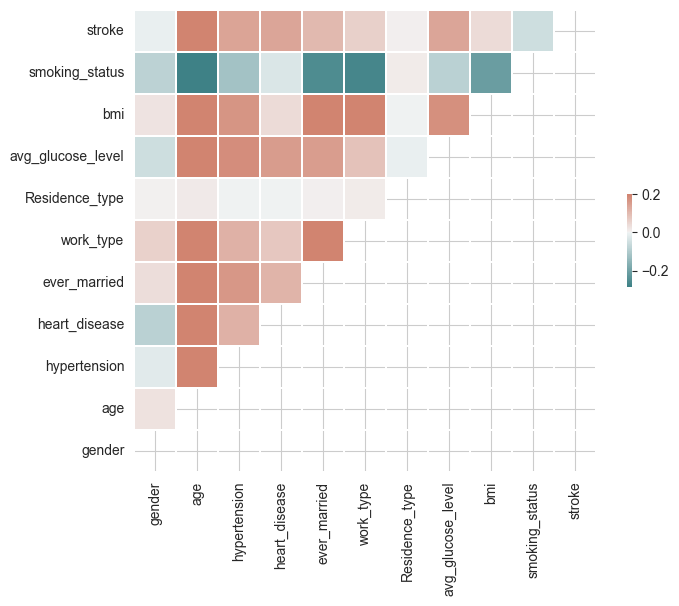

In [16]:
corr = cleaned_data.corr()

# Generate mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))
# Generate a custom diverging colormap
map = sns.diverging_palette(200, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=map, vmax=.2, center=0, square=True, linewidths=.2, cbar_kws={"shrink": .2})
ax.invert_yaxis()

In [17]:
corr

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,1.000000,0.027370,-0.021811,-0.082950,0.036380,0.058783,0.004351,-0.053161,0.026164,-0.081572,-0.006904
age,0.027370,1.000000,0.270538,0.253923,0.630006,0.478369,0.014405,0.234570,0.302588,-0.285745,0.220805
hypertension,-0.021811,0.270538,1.000000,0.115978,0.162350,0.114701,-0.001140,0.180614,0.167770,-0.121841,0.142503
heart_disease,-0.082950,0.253923,0.115978,1.000000,0.111203,0.074964,-0.002409,0.154577,0.041322,-0.032469,0.137929
ever_married,0.036380,0.630006,0.162350,0.111203,1.000000,0.414015,0.004707,0.151657,0.341553,-0.256397,0.105051
work_type,0.058783,0.478369,0.114701,0.074964,0.414015,1.000000,0.012410,0.084738,0.274495,-0.269454,0.059741
Residence_type,0.004351,0.014405,-0.001140,-0.002409,0.004707,0.012410,1.000000,-0.007441,-0.000293,0.012242,0.005988
avg_glucose_level,-0.053161,0.234570,0.180614,0.154577,0.151657,0.084738,-0.007441,1.000000,0.175672,-0.084259,0.138984
bmi,0.026164,0.302588,0.167770,0.041322,0.341553,0.274495,-0.000293,0.175672,1.000000,-0.213190,0.042341
smoking_status,-0.081572,-0.285745,-0.121841,-0.032469,-0.256397,-0.269454,0.012242,-0.084259,-0.213190,1.000000,-0.052609


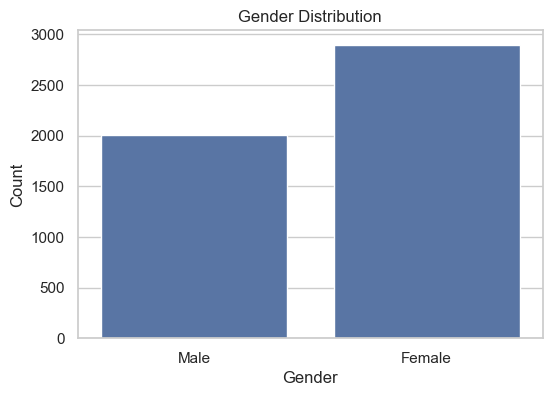

In [18]:
# Define the mapping from numerical value to gender label
gender_labels = {0: 'Male', 1: 'Female'}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x=cleaned_data['gender'].replace(gender_labels))

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

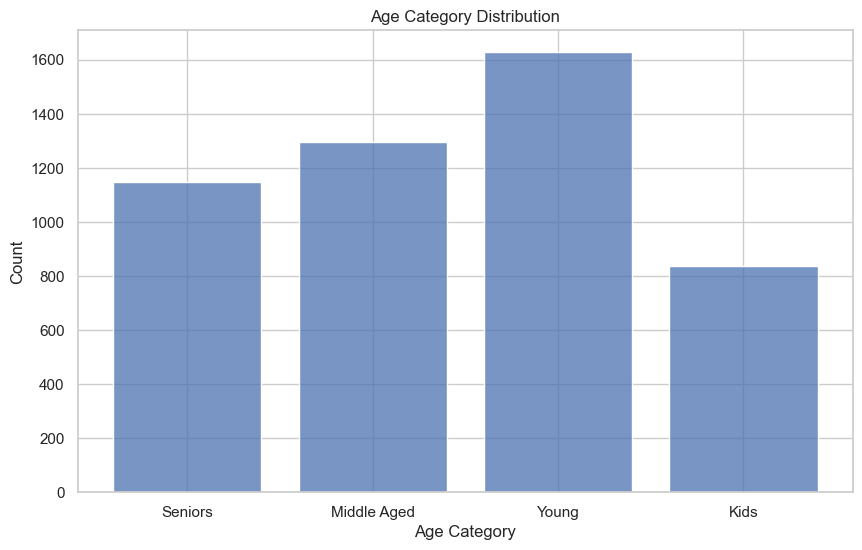

In [19]:
age_labels = {0: 'Kids', 1: 'Young', 2: 'Middle Aged', 3: 'Seniors'}

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(data=cleaned_data['age'].replace(age_labels), discrete=True, shrink=.8)

plt.title('Age Category Distribution')
plt.xlabel('Age Category')
plt.ylabel('Count')

# Show the plot
plt.show()


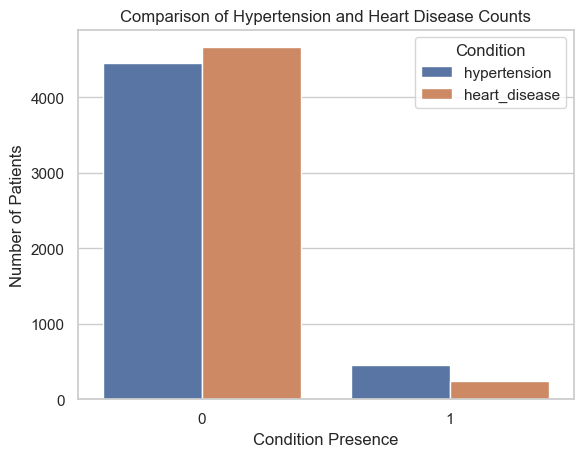

In [20]:
disease_data = cleaned_data.melt(value_vars=['hypertension', 'heart_disease'], var_name='Condition', value_name='Count')

sns.set_theme(style="whitegrid")
ax = sns.countplot(data=disease_data, x='Count', hue='Condition')
ax.set_title('Comparison of Hypertension and Heart Disease Counts')
ax.set_xlabel('Condition Presence')
ax.set_ylabel('Number of Patients')
plt.show()


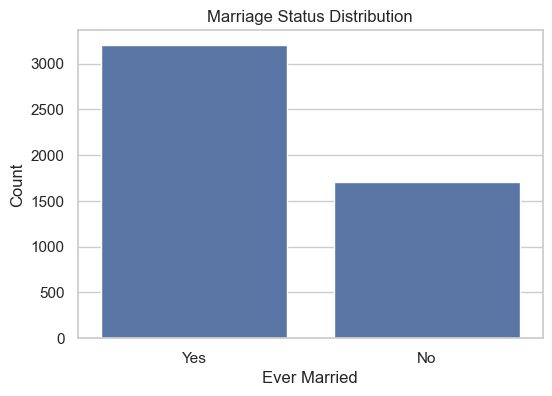

In [21]:
marriage_status_labels = {1: 'Yes', 0: 'No'}

sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.countplot(x=cleaned_data['ever_married'].replace(marriage_status_labels))

plt.title('Marriage Status Distribution')
plt.xlabel('Ever Married')
plt.ylabel('Count')

plt.show()


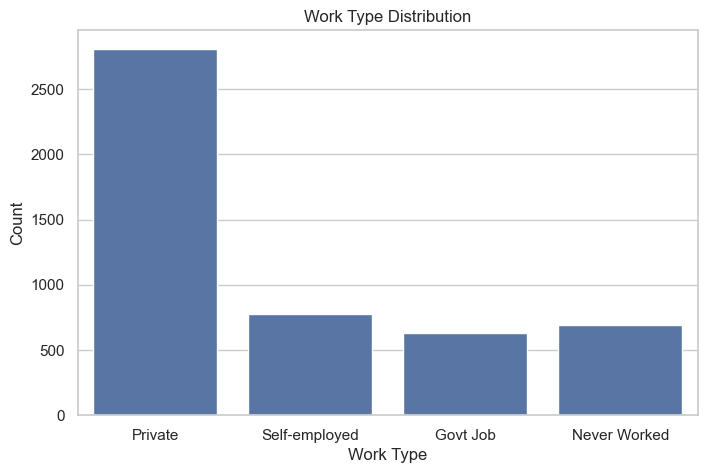

In [22]:
work_type_labels = {0: 'Never Worked', 1: 'Private', 2: 'Self-employed', 3: 'Govt Job'}

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))  
sns.countplot(x=cleaned_data['work_type'].replace(work_type_labels))

plt.title('Work Type Distribution')
plt.xlabel('Work Type')
plt.ylabel('Count')

plt.show()


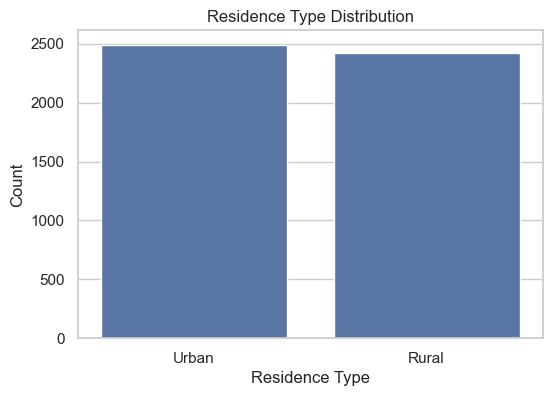

In [23]:
residence_type_labels = {0: 'Rural', 1: 'Urban'}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x=cleaned_data['Residence_type'].replace(residence_type_labels))

plt.title('Residence Type Distribution')
plt.xlabel('Residence Type')
plt.ylabel('Count')

plt.show()


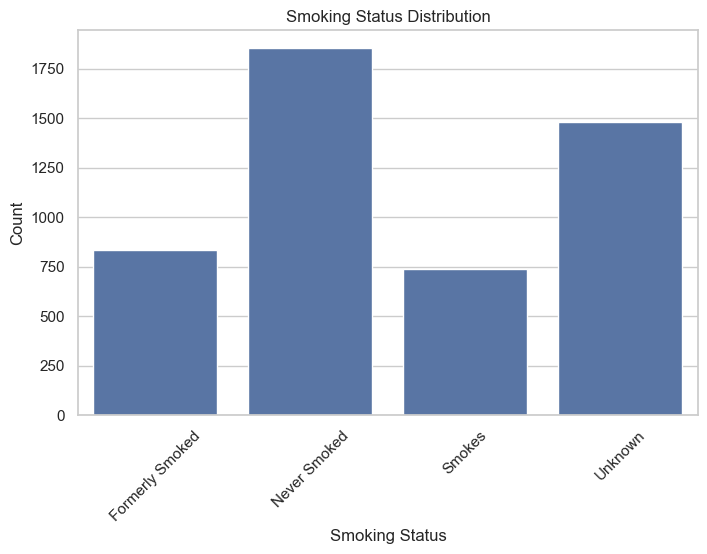

In [24]:
smoking_status_labels = {0: 'Never Smoked', 1: 'Formerly Smoked', 2: 'Smokes', 3: 'Unknown'}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))  
sns.countplot(x=cleaned_data['smoking_status'].replace(smoking_status_labels))


plt.title('Smoking Status Distribution')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


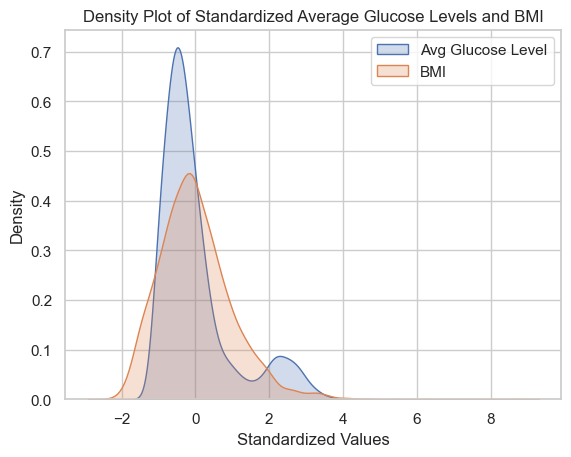

In [25]:
# Plot density plots for both 'avg_glucose_level' and 'bmi'
sns.kdeplot(cleaned_data['avg_glucose_level'], shade=True, label='Avg Glucose Level')
sns.kdeplot(cleaned_data['bmi'], shade=True, label='BMI')

plt.title('Density Plot of Standardized Average Glucose Levels and BMI')
plt.xlabel('Standardized Values')
plt.ylabel('Density')

plt.legend()
plt.show()


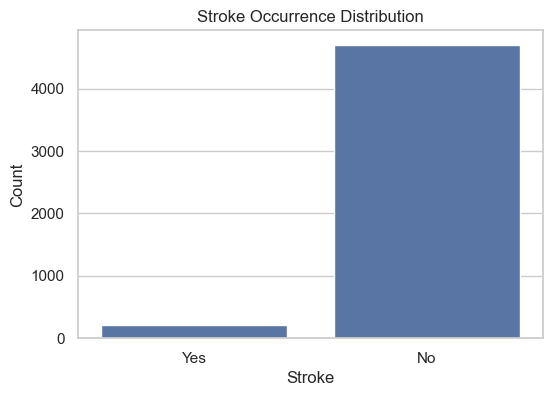

In [26]:
stroke_labels = {1: 'Yes', 0: 'No'}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))  
sns.countplot(x=cleaned_data['stroke'].replace(stroke_labels))

# Add title and labels
plt.title('Stroke Occurrence Distribution')
plt.xlabel('Stroke')
plt.ylabel('Count')

# Show the plot
plt.show()


# 4. SMOTETomek

In [27]:
print("Before SMOTETomek, counts of label '1': {}".format(sum(Y_train==1)))
print("Before SMOTETomek, counts of label '0': {} \n".format(sum(Y_train==0)))

sm = SMOTETomek(random_state=5291)
X_train_resampled, Y_train_resampled = sm.fit_resample(X_train, Y_train)

print('After SMOTETomek, the shape of X_train_resampled: {}'.format(X_train_resampled.shape))
print('After SMOTETomek, the shape of Y_train_resampled: {} \n'.format(Y_train_resampled.shape))

print("After SMOTETomek, counts of label '1': {}".format(sum(Y_train_resampled==1)))
print("After SMOTETomek, counts of label '0': {}".format(sum(Y_train_resampled==0)))

Before SMOTETomek, counts of label '1': 137
Before SMOTETomek, counts of label '0': 3297 

After SMOTETomek, the shape of X_train_resampled: (6576, 10)
After SMOTETomek, the shape of Y_train_resampled: (6576,) 

After SMOTETomek, counts of label '1': 3288
After SMOTETomek, counts of label '0': 3288


# 5. Metrics Functions

In [28]:
# Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
def calculate_metrics(true_labels, predicted_labels, positive_class=1):
    TP = FP = FN = 0
    for true, pred in zip(true_labels, predicted_labels):
        if true == pred == positive_class:
            TP += 1
        elif true != positive_class and pred == positive_class:
            FP += 1
        elif true == positive_class and pred != positive_class:
            FN += 1

    return TP, FP, FN

# Calculate Precision, Recall, and F-measure
def precision_recall_fmeasure(true_labels, predicted_labels, positive_class=1):
    TP, FP, FN = calculate_metrics(true_labels, predicted_labels, positive_class)
    # Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    # Recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    # F-measure
    f_measure = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f_measure


# 6. Models

## 6.1.1 Base Logistic Regression Model

In [29]:
# logistic regression
lr_base = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=5291)
lr_base.fit(X_train_resampled, Y_train_resampled)

Y_val_pred_lrbase = lr_base.predict(X_val)
Y_val_proba_lrbase = lr_base.predict_proba(X_val)[:, 1]

lrbase_val_acc = accuracy_score(Y_val, Y_val_pred_lrbase) # accuracy
lrbase_val_roc_auc = roc_auc_score(Y_val, Y_val_proba_lrbase) # ROC-AUC

# Display 
print(f"Validation Accuracy: {lrbase_val_acc:.4f}")
print(f"Validation ROC-AUC: {lrbase_val_roc_auc:.4f}")
print(confusion_matrix(Y_val, Y_val_pred_lrbase))
print(classification_report(Y_val, Y_val_pred_lrbase))

Validation Accuracy: 0.7313
Validation ROC-AUC: 0.8439
[[510 189]
 [  9  29]]
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       699
           1       0.13      0.76      0.23        38

    accuracy                           0.73       737
   macro avg       0.56      0.75      0.53       737
weighted avg       0.94      0.73      0.81       737


In [30]:
# Get the predicted probabilities for the positive class
Y_val_proba_custom = lr_base.predict_proba(X_val)[:, 1]

# Define a function to apply a threshold to the probabilities
def apply_threshold(probabilities, threshold):
    return np.where(probabilities >= threshold, 1, 0)

# Choose a threshold value
threshold = 0.6

# Apply the custom threshold to get predicted labels
Y_val_pred_custom = apply_threshold(Y_val_proba_custom, threshold)

# Calculate and print the evaluation metrics for the custom threshold predictions
custom_val_acc = accuracy_score(Y_val, Y_val_pred_custom)  # accuracy
custom_val_roc_auc = roc_auc_score(Y_val, Y_val_proba_custom)  # ROC-AUC

# Display results
print(f"Validation Accuracy (Custom Threshold): {custom_val_acc:.4f}")
print(f"Validation ROC-AUC: {custom_val_roc_auc:.4f}")
print(confusion_matrix(Y_val, Y_val_pred_custom))
print(classification_report(Y_val, Y_val_pred_custom))


Validation Accuracy (Custom Threshold): 0.7910
Validation ROC-AUC: 0.8439
[[556 143]
 [ 11  27]]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       699
           1       0.16      0.71      0.26        38

    accuracy                           0.79       737
   macro avg       0.57      0.75      0.57       737
weighted avg       0.94      0.79      0.85       737


## 6.1.2 Hyperparameter Tuning with Grid Search

In [31]:
# Initialize a new logistic regression model
lr_new = LogisticRegression(solver='liblinear', random_state=5291)

# Define the parameter grid for grid search
lrnew_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 10)],
    'penalty': ['l1', 'l2']
}

# Perform grid search
lrnew_grid_search = GridSearchCV(lr_new, lrnew_param_grid, cv=5, scoring='f1', verbose=1)
lrnew_grid_search.fit(X_train_resampled, Y_train_resampled)

# Display the best parameters
print("Best parameters found: ", lrnew_grid_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'C': 1, 'class_weight': {0: 1, 1: 3.111111111111111}, 'penalty': 'l2'}


In [32]:
# Evaluate the Best Model from Grid Search
best_lrnew = lrnew_grid_search.best_estimator_

Y_val_proba_lrnew = best_lrnew.predict_proba(X_val)[:, 1]

precision_lrnew, recall_lrnew, thresholds_lrnew = precision_recall_curve(Y_val, Y_val_proba_lrnew)

# Convert to F1 scores
f1_scores_lrnew = 2*recall_lrnew*precision_lrnew/(recall_lrnew+precision_lrnew)

# Find the optimal threshold that maximizes F1 score
optimal_idx_lrnew = np.argmax(f1_scores_lrnew)
threshold_optimal_lrnew = thresholds_lrnew[optimal_idx_lrnew]

print(f"Optimal threshold for maximizing F1 Score: {threshold_optimal_lrnew}")


Optimal threshold for maximizing F1 Score: 0.95468624472358


In [33]:
# Apply the optimal threshold to get predicted labels
Y_val_pred_optimal_lrnew = (Y_val_proba_lrnew >= threshold_optimal_lrnew).astype(int)

# Calculate accuracy and ROC-AUC for predictions with the optimal threshold
optimal_lrnew_val_acc = accuracy_score(Y_val, Y_val_pred_optimal_lrnew)  # accuracy using the optimal threshold
optimal_lrnew_val_roc_auc = roc_auc_score(Y_val, Y_val_proba_lrnew)  # ROC-AUC using predicted probabilities

# Display results for predictions with the optimal threshold
print(f"Validation Accuracy (Optimal Threshold): {optimal_lrnew_val_acc:.4f}")
print(f"Validation ROC-AUC: {optimal_lrnew_val_roc_auc:.4f}")
print(confusion_matrix(Y_val, Y_val_pred_optimal_lrnew))
print(classification_report(Y_val, Y_val_pred_optimal_lrnew))



Validation Accuracy (Optimal Threshold): 0.9294
Validation ROC-AUC: 0.8416
[[685  14]
 [ 38   0]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       699
           1       0.00      0.00      0.00        38

    accuracy                           0.93       737
   macro avg       0.47      0.49      0.48       737
weighted avg       0.90      0.93      0.91       737


In [34]:
# Apply a fixed threshold of 0.6 to get predicted labels
Y_val_pred_fixed_threshold = (Y_val_proba_lrnew >= 0.6).astype(int)

# Get default predictions and predicted probabilities using the best estimator from the grid search
Y_val_pred_default = best_lrnew.predict(X_val)
Y_val_proba_default = best_lrnew.predict_proba(X_val)[:, 1]

# Calculate accuracy and ROC-AUC using default predictions
default_val_acc = accuracy_score(Y_val, Y_val_pred_default)  # accuracy
default_val_roc_auc = roc_auc_score(Y_val, Y_val_proba_default)  # ROC-AUC

# Display results for default predictions
print(f"Validation Accuracy (Default Threshold): {default_val_acc:.4f}")
print(f"Validation ROC-AUC: {default_val_roc_auc:.4f}")
print(confusion_matrix(Y_val, Y_val_pred_fixed_threshold))
print(classification_report(Y_val, Y_val_pred_fixed_threshold))


Validation Accuracy (Default Threshold): 0.5577
Validation ROC-AUC: 0.8416
[[423 276]
 [  2  36]]
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       699
           1       0.12      0.95      0.21        38

    accuracy                           0.62       737
   macro avg       0.56      0.78      0.48       737
weighted avg       0.95      0.62      0.72       737


## 6.2 SVM

In [35]:
# Fit an SVM classifier
svm_base = SVC(random_state=5291, probability=True)
svm_base.fit(X_train_resampled, Y_train_resampled)

Y_val_svmbase = svm_base.predict(X_val)
val_acc_svmbase = accuracy_score(Y_val, Y_val_svmbase)

# ROC-AUC
Y_val_proba_svmbase = svm_base.predict_proba(X_val)[:, 1]
val_roc_auc_svmbase = roc_auc_score(Y_val, Y_val_proba_svmbase)

svmbase_val_confusion_matrix = confusion_matrix(Y_val, Y_val_svmbase) # Confusion Matrix
svmbase_val_classification_report = classification_report(Y_val, Y_val_svmbase, target_names=['0', '1']) # Classification report

print(f"Validation accuracy: {val_acc_svmbase:.4f}")
print(f"Validation ROC-AUC: {val_roc_auc_svmbase:.4f}")
print(svmbase_val_confusion_matrix)
print(svmbase_val_classification_report)

Validation accuracy: 0.7517
Validation ROC-AUC: 0.7466
[[534 165]
 [ 18  20]]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       699
           1       0.11      0.53      0.18        38

    accuracy                           0.75       737
   macro avg       0.54      0.65      0.52       737
weighted avg       0.92      0.75      0.82       737


## 6.2.2 Improving SVM

In [36]:
# Define the SVM classifier with balanced class weights
svm_new = SVC(random_state=5291, class_weight='balanced', probability=True)

# Define the parameter distribution for RandomizedSearchCV
svm_param_dist = {
    'C': stats.uniform(0.1, 100),  # Continuous distribution from 0.1 to 100
    'kernel': ['linear', 'rbf'],   # Discrete distribution over kernels
    'gamma': ['scale', 'auto']     # Discrete distribution over gamma values
}

# Define the randomized search
random_search = RandomizedSearchCV(svm_new, param_distributions=svm_param_dist, n_iter=2, cv=3, scoring='roc_auc', n_jobs=-1, random_state=5291)

# Fit the randomized search to the data
random_search.fit(X_train, Y_train)

# Get the best model
svmnew_best_model = random_search.best_estimator_

# Predict on the validation set using the best model
Y_val_pred_svmnew = svmnew_best_model.predict(X_val)
Y_val_proba_svmnew = svmnew_best_model.predict_proba(X_val)[:, 1]

# Metrics
svmnew_val_acc = accuracy_score(Y_val, Y_val_pred_svmnew)
svmnew_val_roc_auc = roc_auc_score(Y_val, Y_val_proba_svmnew)
svmnew_val_confusion_matrix = confusion_matrix(Y_val, Y_val_pred_svmnew)
svmnew_val_classification_report = classification_report(Y_val, Y_val_pred_svmnew)

print(f"Validation accuracy: {svmnew_val_acc:.4f}")
print(f"Validation ROC-AUC: {svmnew_val_roc_auc:.4f}")
print(svmnew_val_confusion_matrix)
print(svmnew_val_classification_report)


Validation accuracy: 0.7123
Validation ROC-AUC: 0.8478
[[493 206]
 [  6  32]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.82       699
           1       0.13      0.84      0.23        38

    accuracy                           0.71       737
   macro avg       0.56      0.77      0.53       737
weighted avg       0.94      0.71      0.79       737


## 6.3 Random Forest

In [37]:
# Adjust class weights
rf_class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(Y_train_resampled),
                                                 y=Y_train_resampled)
rf_class_weights_dict = {0: rf_class_weights[0], 1: rf_class_weights[1]}

In [38]:
# Initialization
rf_classifier = RandomForestClassifier(class_weight=rf_class_weights_dict, random_state=5291)

In [39]:
# Define hyperparameters
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

In [40]:
# Perform Grid Search with Cross-Validation
cv_rf_classifier = GridSearchCV(estimator=rf_classifier, param_grid=rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# Fit the grid search
cv_rf_classifier.fit(X_train_resampled, Y_train_resampled)
# Print the best parameters found by GridSearchCV
print("Best Parameters found by GridSearchCV:", cv_rf_classifier.best_params_)

Best Parameters found by GridSearchCV: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [41]:
# Train the final model with the best parameters found
final_rf_classifier = cv_rf_classifier.best_estimator_
# Fit the  model
final_rf_classifier.fit(X_train_resampled, Y_train_resampled)

RandomForestClassifier(bootstrap=False, class_weight={0: 1.0, 1: 1.0},
                       max_depth=30, n_estimators=300, random_state=5291)

In [42]:
# Predict on the validation set
Y_val_rf_pred = final_rf_classifier.predict(X_val)
Y_val_rf_proba = final_rf_classifier.predict_proba(X_val)[:, 1]  # probabilities for the positive class

rf_val_accuracy = accuracy_score(Y_val, Y_val_rf_pred) # accuracy
rf_val_roc_auc = roc_auc_score(Y_val, Y_val_rf_proba)  # Compute ROC-AUC

rf_val_confusion_matrix = confusion_matrix(Y_val, Y_val_rf_pred) # confusion matrix
rf_val_classification_report = classification_report(Y_val, Y_val_rf_pred, target_names=['0', '1']) # classification report

# Display 
print(f"Validation Accuracy: {rf_val_accuracy:.4f}")
print(f"Validation ROC-AUC: {rf_val_roc_auc:.4f}")
print(rf_val_confusion_matrix)
print(rf_val_classification_report)


Validation Accuracy: 0.8874
Validation ROC-AUC: 0.7623
[[649  50]
 [ 33   5]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       699
           1       0.09      0.13      0.11        38

    accuracy                           0.89       737
   macro avg       0.52      0.53      0.52       737
weighted avg       0.91      0.89      0.90       737


## 6.4.1 MLPs

In [43]:
# Constructing the MLP Model
mlp_input_dim = X_train_resampled.shape[1]

mlp_model = Sequential([
    Dense(64, input_dim=mlp_input_dim, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compiling the Model
mlp_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
# Adjust Class Weights
mlp_class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled.ravel())
mlp_class_weights_dict = dict(enumerate(mlp_class_weights))

In [45]:
# Train the Model
history = mlp_model.fit(
    X_train_resampled,
    Y_train_resampled,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=mlp_class_weights_dict,
    verbose=0 
)

In [46]:
# Evaluation
mlp_Y_val_pred = (mlp_model.predict(X_val) > 0.5).astype("int32")
mlp_val_loss, mlp_val_accuracy = mlp_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Loss:", mlp_val_loss)
print("Validation Accuracy:", mlp_val_accuracy)
print(confusion_matrix(Y_val, mlp_Y_val_pred))
print(classification_report(Y_val, mlp_Y_val_pred))

24/24 [==============================] - 0s 737us/step
Validation Loss: 0.44553452730178833
Validation Accuracy: 0.7829036712646484
[[557 142]
 [ 18  20]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.87       699
           1       0.12      0.53      0.20        38

    accuracy                           0.78       737
   macro avg       0.55      0.66      0.54       737
weighted avg       0.93      0.78      0.84       737


## 6.4.2 MLPs New

In [47]:
# # Update the Model Architecture with Regularization
# model = Sequential()
# model.add(InputLayer(input_shape=(input_dim,)))
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# 
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# 
# # Adjust class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
# class_weights_dict = dict(enumerate(class_weights))
# 
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# 
# checkpoint = ModelCheckpoint(
#     'best_model.h5', 
#     monitor='val_loss', 
#     save_best_only=True, 
#     save_weights_only=False,
#     mode='min', 
#     verbose=0
# )
# 
# history = model.fit(
#     X_train_resampled,
#     Y_train_resampled,
#     validation_data=(X_val, Y_val),
#     epochs=100,
#     batch_size=32,
#     class_weight=class_weights_dict,
#     callbacks=[early_stopping, checkpoint],
#     verbose=0
# )

In [48]:
"""
    Last cell was commented out, because training this model is time-consuming.
    The model is trained and saved local as a 'h5' file, and that file is also uploaded.
    So if you would like to run the code, please simply run this code,
    and please double check the working directory. (or change the path)
    Thank you.
"""

# Load the saved model
mlp_new_model = load_model('best_model.h5')

# Evaluate on the validation set
mlpnew_val_loss, mlpnew_val_accuracy = mlp_new_model.evaluate(X_val, Y_val, verbose=0)

# Generate predictions and evaluate the model's performance
Y_val_probs_mlpnew = mlp_new_model.predict(X_val).ravel()  # Flattening to 1D array if necessary
Y_val_pred_mlpnew = (Y_val_probs_mlpnew > 0.5).astype("int32")

# Calculate accuracy and ROC-AUC
mlpnew_val_acc = accuracy_score(Y_val, Y_val_pred_mlpnew)  # accuracy
mlpnew_val_roc_auc = roc_auc_score(Y_val, Y_val_probs_mlpnew)  # ROC-AUC

# Display
print(f"Validation Accuracy: {mlpnew_val_acc:.4f}")
print(f"Validation ROC-AUC: {mlpnew_val_roc_auc:.4f}")
print(confusion_matrix(Y_val, Y_val_pred_mlpnew))
print(classification_report(Y_val, Y_val_pred_mlpnew))


24/24 [==============================] - 0s 1ms/step
Validation Accuracy: 0.7666
Validation ROC-AUC: 0.8256
[[540 159]
 [ 13  25]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       699
           1       0.14      0.66      0.23        38

    accuracy                           0.77       737
   macro avg       0.56      0.72      0.54       737
weighted avg       0.93      0.77      0.83       737


# 7. Evaluation on Test Set

## 7.1.1 Logistic 1 base model with default threshold

In [49]:
# Predict on the testing set
Y_test_pred_lrbase = lr_base.predict(X_test)
Y_test_proba_lrbase = lr_base.predict_proba(X_test)[:, 1]

# Calculate the metrics for the testing set
lrbase_test_acc = accuracy_score(Y_test, Y_test_pred_lrbase) # accuracy
lrbase_test_roc_auc = roc_auc_score(Y_test, Y_test_proba_lrbase) # ROC-AUC

# Display the metrics
print(f"Testing Accuracy: {lrbase_test_acc:.4f}")
print(f"Testing ROC-AUC: {lrbase_test_roc_auc:.4f}")
print(confusion_matrix(Y_test, Y_test_pred_lrbase))
print(classification_report(Y_test, Y_test_pred_lrbase))


Testing Accuracy: 0.7151
Testing ROC-AUC: 0.7861
[[504 199]
 [ 11  23]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       703
           1       0.10      0.68      0.18        34

    accuracy                           0.72       737
   macro avg       0.54      0.70      0.50       737
weighted avg       0.94      0.72      0.80       737


## 7.1.2 Logistic 2

In [50]:
# Apply a fixed threshold of 0.6 to get predicted labels on the test set
Y_test_pred_fixed_threshold = (best_lrnew.predict_proba(X_test)[:, 1] >= 0.6).astype(int)

fixed_threshold_test_acc = accuracy_score(Y_test, Y_test_pred_fixed_threshold)  # accuracy
fixed_threshold_test_roc_auc = roc_auc_score(Y_test, best_lrnew.predict_proba(X_test)[:, 1])  # ROC-AUC using predicted probabilities

print(f"Test Accuracy (Fixed Threshold 0.6): {fixed_threshold_test_acc:.4f}")
print(f"Test ROC-AUC (Fixed Threshold 0.6): {fixed_threshold_test_roc_auc:.4f}")
print(confusion_matrix(Y_test, Y_test_pred_fixed_threshold))
print(classification_report(Y_test, Y_test_pred_fixed_threshold))


Test Accuracy (Fixed Threshold 0.6): 0.5916
Test ROC-AUC (Fixed Threshold 0.6): 0.7911
[[406 297]
 [  4  30]]
              precision    recall  f1-score   support

           0       0.99      0.58      0.73       703
           1       0.09      0.88      0.17        34

    accuracy                           0.59       737
   macro avg       0.54      0.73      0.45       737
weighted avg       0.95      0.59      0.70       737


## 7.2 SVM

In [51]:
# Predict on the testing set using the best model
Y_test_pred_svmnew = svmnew_best_model.predict(X_test)
Y_test_proba_svmnew = svmnew_best_model.predict_proba(X_test)[:, 1]

# Metrics
svmnew_test_acc = accuracy_score(Y_test, Y_test_pred_svmnew)
svmnew_test_roc_auc = roc_auc_score(Y_test, Y_test_proba_svmnew)
svmnew_test_confusion_matrix = confusion_matrix(Y_test, Y_test_pred_svmnew)
svmnew_test_classification_report = classification_report(Y_test, Y_test_pred_svmnew)

print(f"Testing accuracy: {svmnew_test_acc:.4f}")
print(f"Testing ROC-AUC: {svmnew_test_roc_auc:.4f}")
print(svmnew_test_confusion_matrix)
print(svmnew_test_classification_report)


Testing accuracy: 0.6947
Testing ROC-AUC: 0.8383
[[484 219]
 [  6  28]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       703
           1       0.11      0.82      0.20        34

    accuracy                           0.69       737
   macro avg       0.55      0.76      0.51       737
weighted avg       0.95      0.69      0.78       737


## 7.3 Random Forest

In [52]:
# Predict on the testing set
Y_test_rf_pred = final_rf_classifier.predict(X_test)
Y_test_rf_proba = final_rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for the positive class

rf_test_accuracy = accuracy_score(Y_test, Y_test_rf_pred)  # accuracy
rf_test_roc_auc = roc_auc_score(Y_test, Y_test_rf_proba)  # Compute ROC-AUC

rf_test_confusion_matrix = confusion_matrix(Y_test, Y_test_rf_pred)  # confusion matrix
rf_test_classification_report = classification_report(Y_test, Y_test_rf_pred, target_names=['0', '1'])  # classification report

# Display 
print(f"Testing Accuracy: {rf_test_accuracy:.4f}")
print(f"Testing ROC-AUC: {rf_test_roc_auc:.4f}")
print(rf_test_confusion_matrix)
print(rf_test_classification_report)


Testing Accuracy: 0.8969
Testing ROC-AUC: 0.7342
[[657  46]
 [ 30   4]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       703
           1       0.08      0.12      0.10        34

    accuracy                           0.90       737
   macro avg       0.52      0.53      0.52       737
weighted avg       0.92      0.90      0.91       737


## 7.4 MLPs

In [53]:
# Load the saved model
mlp_new_model = load_model('best_model.h5')

mlpnew_test_loss, mlpnew_test_accuracy = mlp_new_model.evaluate(X_test, Y_test, verbose=0)

Y_test_probs_mlpnew = mlp_new_model.predict(X_test).ravel()
Y_test_pred_mlpnew = (Y_test_probs_mlpnew > 0.5).astype("int32")

mlpnew_test_acc = accuracy_score(Y_test, Y_test_pred_mlpnew)  # accuracy
mlpnew_test_roc_auc = roc_auc_score(Y_test, Y_test_probs_mlpnew)  # ROC-AUC

# Display 
print(f"Testing Accuracy: {mlpnew_test_acc:.4f}")
print(f"Testing ROC-AUC: {mlpnew_test_roc_auc:.4f}")
print(confusion_matrix(Y_test, Y_test_pred_mlpnew))
print(classification_report(Y_test, Y_test_pred_mlpnew))

24/24 [==============================] - 0s 694us/step
Testing Accuracy: 0.7558
Testing ROC-AUC: 0.7833
[[534 169]
 [ 11  23]]
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       703
           1       0.12      0.68      0.20        34

    accuracy                           0.76       737
   macro avg       0.55      0.72      0.53       737
weighted avg       0.94      0.76      0.83       737


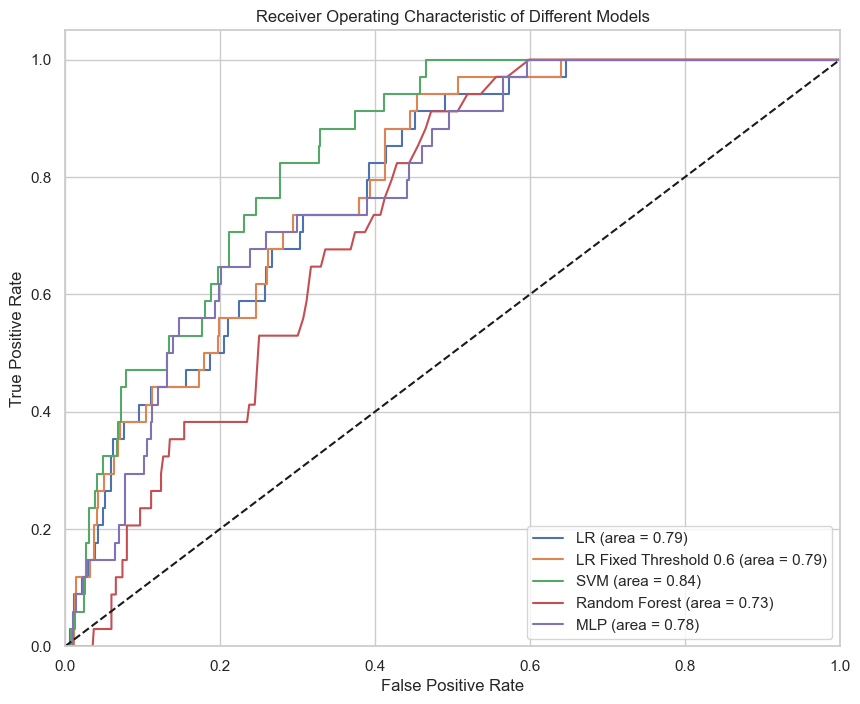

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and ROC area for each model
models = [
    ('LR', Y_test_proba_lrbase),
    ('LR Fixed Threshold 0.6', best_lrnew.predict_proba(X_test)[:, 1]),
    ('SVM', Y_test_proba_svmnew),
    ('Random Forest', Y_test_rf_proba),
    ('MLP', Y_test_probs_mlpnew)
]
plt.figure(figsize=(10, 8))

for model_name, y_test_proba in models:
    fpr, tpr, _ = roc_curve(Y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Different Models')
plt.legend(loc="lower right")
plt.show()


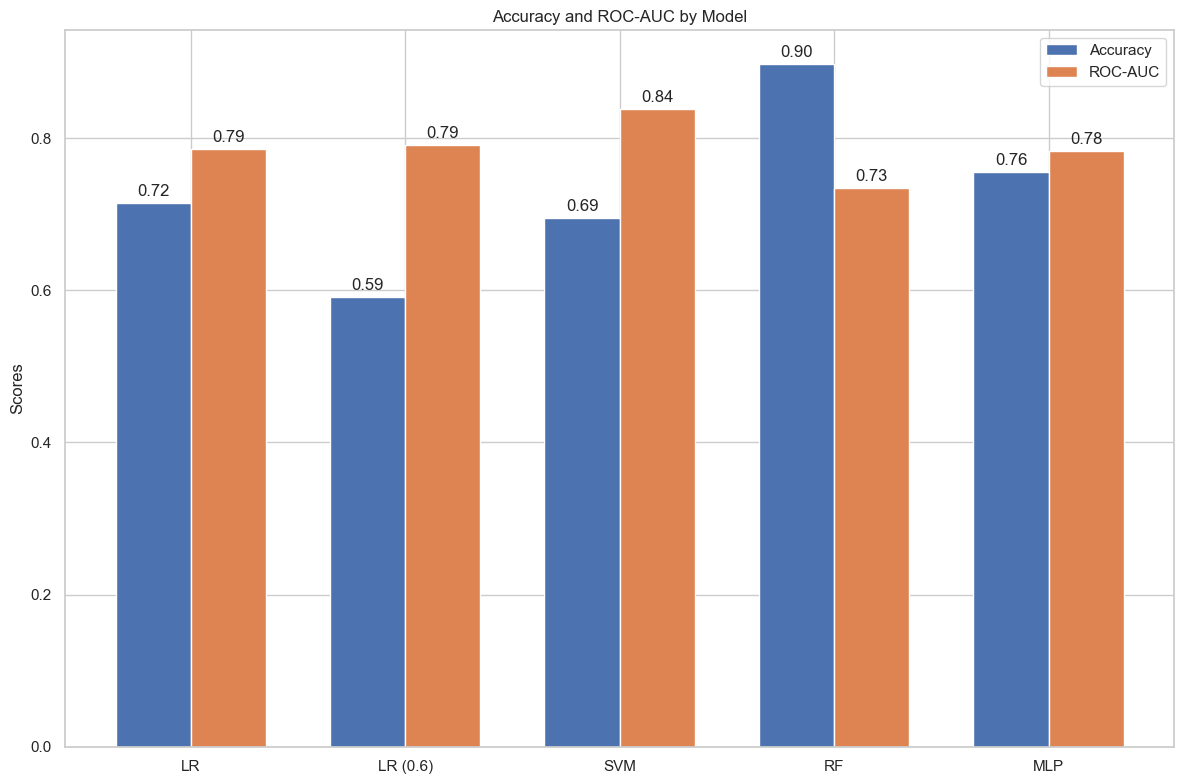

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics for each model
accuracies = [lrbase_test_acc, fixed_threshold_test_acc, svmnew_test_acc, rf_test_accuracy, mlpnew_test_acc]
roc_aucs = [lrbase_test_roc_auc, fixed_threshold_test_roc_auc, svmnew_test_roc_auc, rf_test_roc_auc, mlpnew_test_roc_auc]
model_names = ['LR', 'LR (0.6)', 'SVM', 'RF', 'MLP']

# Set up the bar chart
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, roc_aucs, width, label='ROC-AUC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Accuracy and ROC-AUC by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()
